# Assignment 13: Interpolation, Gaussian process regression, and kriging
#### 9th December 2022

In [1]:
# edapy_10_00 clear all variables and import vatious modules

# History
# 2022/06/26 -  checked with most recent Python & etc. software

%reset -f
import os
from datetime import date
from math import exp, pi, sin, cos, tan, sqrt, floor, ceil, log
import numpy as np
import scipy.sparse.linalg as las
import scipy.interpolate as ip
import scipy.spatial as sp
from scipy import sparse
import scipy.linalg as la
import scipy.signal as sg
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap


# eda_draw function makes a "pictorial matrix equation"
# arguments are vectors, matrices and strings
# which are plotted in the order that the appear
# except that strings starting with 'title ' are plotted
# under the subseqeunt matrix or vector
# always returns a status of 1
def eda_draw(*argv):
    bw = np.zeros((256,4));
    v = 0.9*(256 - np.linspace( 0, 255, 256 ))/255;
    bw[:,0] = v;
    bw[:,1] = v;
    bw[:,2] = v;
    bw[:,3] = np.ones(256);
    bwcmap = ListedColormap(bw);
    # size of plot
    W = 16;
    H = 4;
    fig1 = plt.figure(1);
    # figsize width and height in inches
    fig1.set_size_inches(W,H);
    ax1 = plt.subplot(1,1,1);
    plt.axis([0, W, -H/2, H/2]);
    plt.axis('off');
    LM = W/6;    # matrix width and heoght
    LV = W/40;   # vector width
    FS = 0.12;    # character width
    TO = 0.4;    # title vertical offset
    SP = 0.2;    # space between objects
    LS = 0.2;    # leading space
    p = LS; # starting x-position
    istitle=0; # flags presence of a title
    for a in argv:
        if isinstance(a,np.ndarray):
            sh = np.shape(a);
            if len(sh) == 1:  # conversion to nx1 array
                n = sh[0];
                m = 1;
                ap = a;
                a = np.zeros((n,1));
                a[:,0] = ap;
            else:
                n = sh[0];
                m = sh[1];
            if m==1:
                pold=p;
                left=p;
                right=p+LV;
                bottom=-LM/2;
                top=LM/2;
                plt.imshow( a, cmap=bwcmap, vmin=np.min(a), vmax=np.max(a), extent=(left,right,bottom,top) );
                p = p+LV;
                pm = (p+pold)/2;
                if istitle:
                    plt.text(pm,-(LM/2)-TO,titlestr,horizontalalignment='center');
                    istitle=0;
                p = p+SP;
            else:
                pold=p;
                left=p;
                right=p+LM;
                bottom=-LM/2;
                top=LM/2;
                plt.imshow( a, cmap=bwcmap, vmin=np.min(a), vmax=np.max(a), extent=(left,right,bottom,top) );
                p = p+LM;
                pm = (p+pold)/2;
                if istitle:
                    plt.text(pm,-(LM/2)-TO,titlestr,horizontalalignment='center');
                    istitle=0;
                p = p+SP;
        elif isinstance(a,str):
            ns = len(a);
            istitle=0;
            if( ns>=6 ):
                if 'title ' in a[0:6]:
                    istitle=1;
                    titlestr=a[6:];
            if( istitle != 1):
                plt.text(p,0,a);
                p = p + ns*FS + SP;
    plt.show();
    return 1;


def FTFmul(v):
    # this function is used by the bicongugate gradient solver to solve the geneneralized least
    # squares problem Fm=f.  Note that "F" must be called "edaFsparse".
    global edaFsparse;
    s = np.shape(v);
    if(len(s)==1):
        vv = np.zeros((s[0],1));
        vv[:,0] = v;
    else:
        vv=v;
    temp = edaFsparse*vv;
    return edaFsparse.transpose()*temp;


def GLSFilterMul(v):
    # this function is used by the bicongugate gradient solver to solve the
    # geneneralized least squares problem Fm=f with F=[G;H] and f=[d,h],
    # where G is a topplitz matrix built from the filter g
    # Note that "H" must be sparese and called "edaHsparse" and that
    # the filter "g" bust be called edafilterg and must be a column vector
    global edaHsparse;
    global edafilterg;
    # rearrange as column-vector
    s = np.shape(v);
    M = s[0];
    if(len(s)==1):
        vv = np.zeros((s[0],1));
        vv[:,0] = v;
    else:
        vv=v;
    N, i = np.shape(edafilterg);
    # implements (GT G + HT H) v
    temp1 = np.zeros((N+M-1,1));
    temp1[:,0] = np.convolve(edafilterg.ravel(),vv.ravel()); # G v is of length N
    a = np.zeros((N,1));
    a[:,0] = temp1[0:N,0];
    b = edaHsparse * v; # H v is of length K
    temp2 = np.zeros((N+N-1,1));
    temp2[:,0] = np.convolve((np.flipud(edafilterg)).ravel(),a.ravel()); # GT (G v) is of length M
    a2 = temp2[N-1:N+M-1,0];
    b2 = edaHsparse.transpose()*b; # HT (H v) is of length M
    # FT F v = GT G v + HT H v
    return (a2+b2);


def GLSautoMul(v):
    # this function is used by the bicongugate gradient solver to solve the
    # geneneralized least squares problem Fm=f with F=[G;H] and f=[d,h],
    # where GTG is built from the autocorrelation of the filter g
    global edaHsparse;
    global edaautoc;
    # rearrange as column-vector
    s = np.shape(v);
    M = s[0];
    if(len(s)==1):
        vv = np.zeros((s[0],1));
        vv[:,0] = v;
    else:
        vv=v;
    # FT F v = GT G v + HT H v
    GTGv=np.zeros((M,1));
    for i in range(M):
        u = np.concatenate( (np.flipud(edaautoc[0:i+1,0]), edaautoc[1:M-i,0]), axis=0 );
        GTGv[i,0] =  np.matmul( u.T, vv );
    Hv = edaHsparse*vv;
    HTHv = edaHsparse.transpose()*Hv;
    return (GTGv + HTHv);


def chebyshevfilt(d, Dt, flow, fhigh):
    #chebyshevfilt
    # chebyshev IIR bandpass filter
    # d - input array of data
    # Dt - sampling interval
    # flow - low pass frequency, Hz
    # fhigh - high pass frequency, Hz
    # dout - output array of data
    # u - the numerator filter
    # v - the denominator filter
    # these filters can be used again using dout=filter(u,v,din);

    # make sure input timeseries is a column vector
    s = np.shape(d);
    N = s[0];
    if(N==1):
        dd = np.zeros((N,1));
        dd[:,0] = d;
    else:
        dd=d;
        
    # sampling rate
    rate=1/Dt;

    # ripple parameter, set to ten percent
    ripple=0.1;  

    # normalise frequency
    fl=2.0*flow/rate;
    fh=2.0*fhigh/rate;

    # center frequency 
    cf = 4 * tan( (fl*pi/2) ) * tan( (fh*pi/2) );

    # bandwidth
    bw = 2 * ( tan( (fh*pi/2) ) - tan( (fl*pi/2) ) );

    # ripple parameter factor
    rpf = sqrt((sqrt((1.0+1.0/(ripple*ripple))) + 1.0/ripple));
    a = 0.5*(rpf-1.0/rpf);
    b = 0.5*(rpf+1.0/rpf);

    u=np.zeros((5,1));
    v=np.zeros((5,1));
    theta = 3*pi/4;
    sr = a * cos(theta);
    si = b * sin(theta);
    es = sqrt(sr*sr+si*si);
    tmp= 16.0 - 16.0*bw*sr + 8.0*cf + 4.0*es*es*bw*bw - 4.0*bw*cf*sr + cf*cf;
    v[0,0] = 1.0;
    v[1,0] = 4.0*(-16.0 + 8.0*bw*sr - 2.0*bw*cf*sr + cf*cf)/tmp;
    v[2,0] = (96.0 - 16.0*cf - 8.0*es*es*bw*bw + 6.0*cf*cf)/tmp;
    v[3,0] = (-64.0 - 32.0*bw*sr + 8.0*bw*cf*sr + 4.0*cf*cf)/tmp;
    v[4,0] = (16.0 + 16.0*bw*sr + 8.0*cf + 4.0*es*es*bw*bw + 4.0*bw*cf*sr + cf*cf)/tmp;
    tmp = 4.0*es*es*bw*bw/tmp;
    u[0,0] = tmp;
    u[1,0] = 0.0;
    u[2,0] = -2.0*tmp;
    u[3,0] = 0.0;
    u[4,0] = tmp;

    dout = sg.lfilter(u.ravel(),v.ravel(),dd.ravel());
    return (dout,u,v);

# function to make a numpy N-by-1 column vector
# c=eda_cvec1(v) from entity v that is array-like,
# including a number, a list of numbers, a tuple
# of numbers, an N-by-0 np array and a N-by1 np array.
# It promotes integers to floats, and integers
# and floats to complex, by context. The function
# also insures that, if v is an np array, that
# c is a copy, as contrasted to a view, of it.
# This version takes just one input argment.
# whereas c=eda_cvec(v1,v2,...) concatenates
# many argiments.
def eda_cvec1(v):
    if isinstance(v, int):
        w = np.zeros((1,1),dtype=int);
        w[0,0] = v;
        return w;
    elif isinstance(v, float):
        w = np.zeros((1,1),dtype=float);
        w[0,0] = v;
        return w;
    elif isinstance(v, complex):
        w = np.zeros((1,1),dtype=complex);
        w[0,0] = v;
        return w;
    elif isinstance(v, np.ndarray):
        s = np.shape(v);
        if len(s) == 1:
            return np.copy(np.reshape(v,(s[0],1)));
        else:
            [r,c]=s;
            if( c==1 ):
                return(np.copy(v));
            elif(r==1):
                return(np.copy(v.T));
            else:
                raise TypeError("eda_cvec: %d by %d ndarray not allowed" % (r, c));
    elif isinstance(v, list):
        r = len(v);
        t = int;
        for vi in v:
            if isinstance(vi,int):
                pass;
            elif isinstance(vi,float):
                t=float;
            elif isinstance(vi,complex):
                t=complex;
                break;
            else:
                raise TypeError("eda_cvec: list contains unsupported type %s" % type(vi));
        w = np.zeros((r,1),dtype=t);
        w[:,0] = v;
        return w;
    elif isinstance(v, tuple):
        r = len(v);
        t = int;
        for vi in v:
            if isinstance(vi,int):
                pass;
            elif isinstance(vi,float):
                t=float;
            elif isinstance(vi,complex):
                t=complex;
                break;
            else:
                raise TypeError("eda_cvec: tuple contains unsupported type %s" % type(vi));
        w = np.zeros((r,1),dtype=t);
        w[:,0] = v;
        return w;
    else:
        raise TypeError("eda_cvec: %s not supported" % type(v));
        
# function to make a numpy N-by-1 column vector
# c=eda_cvec(v1, v2, ...) from a list of several
# array-like entities v1, v2, including a number
# a list of numbers, a tuple of numbers, an N-by-0 np array
# and a N-by-1 np array. The function
# also insures that, if v is an np array, that
# c is a copy, as contrasted to a view, of it
# It promotes integers to floats, and integers
# and floats to complex, by context.
# This version concatenates many argments,
# whereas c=eda_cvec1(v1) takes just one argiment.
# I recommend always using eda_cvec(v1, v2, ...)
def eda_cvec(*argv):
    t = int;
    Nt = 0;
    for a in argv:
        v = eda_cvec1(a);
        N,M = np.shape(v);
        Nt = Nt + N;
        if( N==0 ):
            continue; # skip vector of zero length
        if (t==int) and isinstance(v[0,0],float):
            t=float;
        elif isinstance(v[0,0],complex):
            t=complex;
    w = np.zeros((Nt,1),dtype=t);
    Nt = 0;
    for a in argv:
        v = eda_cvec1(a);
        N,M = np.shape(v);
        w[Nt:Nt+N,0] = v[0:N,0];
        Nt = Nt + N;
    return w;

def eda_sign(x):
# sign function; apparently Python doesn't have one
    if x>0.0:
        s=1.0;
    elif x<0.0:
        s=(-1.0);
    else:
        s=0.0;
    return(s);

# function to perform the multiplication y = (Ccc + sigmad2 I) v
def eda_CpImul(v):
    global eda_N;
    global eda_td;
    global eda_sigmad2;
    global eda_gamma2;
    global eda_w0est;
    global eda_sest;

    # rearrange as column-vector
    s = np.shape(v);
    M = s[0];
    if(len(s)==1):
        vv = np.zeros((s[0],1));
        vv[:,0] = v;
    else:
        vv=v;
# Note (C + sigmad2 I) v implies yi = SUMj Cij vj + sigmad2 vi
    y = np.zeros((eda_N,1));
    for i in range(eda_N):
        y[i,0]=eda_sigmad2*vv[i,0];
        for j in range(eda_N):
            Tabs = abs(eda_td[i,0]-eda_td[j,0]);
            Cij = eda_gamma2*cos(eda_w0est*Tabs)*exp(-eda_sest*Tabs);
            y[i,0]=y[i,0]+Cij*vv[j,0];
    return y;

## 10.2. Modify the edama_10_05 or edapy_10_05 script to computing the estimate for a variety of different decay rates, s, and frequencies, ω0, of the autocorrelation function. Comment on the results.

In [15]:
# edapy_10_05, Gaussian Process Regression example

def gaussian(ss, n): 
    # tunable parameters
    MPLOT = 5;    # scale of model parameter plot
    CPLOT = 1;    # scale of covariance plot
    gamma = 1;    # sqrt(variance) of covariance
    sigmad = 0.2; # noise level of observed data
    wbias=1.0;    # compute GPR with wrong w0
    sbias=1.0;    # compute GPR with wrong s
    PLOTCONF=1;   # plot confidence intervals on 1
    USEFORRLOOP=0; # for loops on 1, outer products on 0

    # axes definitons

    # model parameter axis, tm, with sampling Dt
    M=256;  # must be even, best if a power of 2
    Dtm=1.0;
    tmax=Dtm*(M-1); 
    tm=Dtm*eda_cvec(np.linspace(0,tmax,M)); 

    K=8; # must be even, best if a power of 2
    Mf=M*K;  
    Dtf=Dtm/K;
    tf=Dtf*eda_cvec(np.linspace(0,Mf-1,Mf));

    # Part 1: realization of a finely sampled time
    # % series, mf, with the desired covariance

    # PART 1: create true "fine" covariance function

    #n=6;  # number of oscillations on (0,tmax) interal
    w0 = n*2*pi/tmax;  # angular frequency of oscilation
    tmid=tmax/2.0;
    s = ss/tmax;     # decay rate
    gamma2 = gamma**2; # variance
    cf = gamma2*np.multiply(np.cos(w0*(tf-tmid)),np.exp(-s*np.abs(tf-tmid)));

    print("gamma: %.4f w0: %.4f s: %.4f n: %.4f" % (gamma, w0, s, n) );

    # PART 2: create "fine" time series with thus
    # covariance using Fourier techniques

    # amplitude spectral density of true covariance
    cftilde = np.fft.fft(cf,axis=0);
    cfasd = np.sqrt(np.abs(cftilde));

    mf = np.random.normal(loc=0.0,scale=1.0,size=(Mf,1));
    mf = mf - np.mean(mf); # remove mean
    mftilde = np.fft.fft(mf,axis=0); # Fourier transform of mf
    mfasd = np.abs(mftilde);   # a.s.d. of mf
    # adjust so has a.s.d. of c
    mftilde = np.multiply(np.divide(cfasd,mfasd),mftilde);
    # inverse Fourier transform
    mf = np.real(np.fft.ifft(mftilde,axis=0));
    varmf = np.var(mf);      # variance of mf
    # normalize mf to variance gamma^2
    mf = (gamma/sqrt(varmf))*mf;

    # PART 3: Regularly sub-sample mf to get mtrue, irregularly
    # sub-sample mf to get true data dtrue, and add uncorrelated
    # noise to dtrue to get observed data dobs

    mtrue = np.copy(mf[0:Mf:K]);

    Ntarget = 50; # fewer observed data than true data
    # create list, j, of N unique, randomly chosen indices
    # that are not in the sequence 1, K+1, 2K+1, ...
    j=np.zeros((Ntarget,1),dtype=int);
    Nj=0;
    while (Nj<Ntarget):
        i=np.random.randint(low=0,high=Mf-1,size=(1));
        if( (((i-1)%K) != 0) and (not np.isin(i,j)) ):
            j[Nj,0]=i;
            Nj=Nj+1;
    # sort for plotting purposes
    j = eda_cvec(np.sort(j.ravel())); 
    j = eda_cvec(np.unique(j.ravel())); 
    N,i = np.shape(j);
    print('target N: %d, actual %d' % (Ntarget,N) );
    # times of observations
    td = np.copy(tf[j.ravel()]); 
    # irregularly sub-sampled data
    dtrue = np.copy(mf[j.ravel()]);  
    # observed data is true data + uncorrelated random noise
    sigmad2 = sigmad**2;
    dobs = dtrue+np.random.normal(loc=0,scale=sigmad,size=(N,1));

    # the data kernel, G, for the equation d=Gm
    G = np.concatenate( (np.zeros((N,M)), np.zeros((N,N))), axis=1 );

    # Since the true (w0, s) are in general unknown
    # this code allows them to be assigned differently
    # from the true values
    w0est = wbias*w0;  # w0est = 1.0*w0 is the true value
    sest = sbias*s;

    if( USEFORRLOOP ):
        # build covariances via for loop
        Ccc = np.zeros((N,N)); # covariance matrix, C(control,control)
        for i in range(N):
            for j in range(N):
                T = abs(td[i,0]-td[j,0]);
                Ccc[i,j] = gamma2*cos(w0est*T)*exp(-sest*T);

        Ctc = np.zeros((M,N)); #  covariance matrix, C(target,control)
        for i in range(M):
            for j in range(N):
                T = abs(tm[i,0]-td[j,0]);
                Ctc[i,j] = gamma2*cos(w0est*T)*exp(-sest*T);   
    else: # use outer product
        # build covariances via outer product
        Tdd = np.abs(np.matmul(td,np.ones((1,N)))-np.matmul(np.ones((N,1)),(td.T)));
        Ccc = gamma2*np.multiply(np.cos(w0est*Tdd),np.exp(-sest*Tdd));
        Tmd = np.abs(np.matmul(tm,np.ones((1,N)))-np.matmul(np.ones((M,1)),(td.T)));
        Ctc = gamma2*np.multiply(np.cos(w0est*Tmd),np.exp(-sest*Tmd));

    # solve GPE problem
    A = (Ccc + sigmad2*np.identity(N) );
    mest = np.matmul(Ctc,la.solve(A,dobs));

    # estimated covariance
    cest = eda_cvec(
        np.correlate(mest.ravel(),mest.ravel(),mode='full'))/M;

    # plot this covariance
    fig1 = plt.figure(1,figsize=(10,6));
    plt.axis([ -tmid, tmid, -CPLOT, CPLOT]);
    plt.xlabel('time lag t (s)');
    plt.ylabel('c(t)');
    plt.plot( tf-tmid,cf,'k-',lw=3);
    tc = eda_cvec(Dtm*np.linspace(-M+1,M-1,2*M-1));
    plt.plot(tc,cest,'k:',lw=3);
    plt.show();

    # time series figure
    fig2 = plt.figure(2,figsize=(10,6));
    plt.axis( [ 0, tmax, -MPLOT, MPLOT] );
    plt.xlabel('time t (s)');
    plt.ylabel('d(t) and  m(t)');
    plt.plot(tm,mtrue,'k-',lw=3);
    plt.plot(td,dtrue,'ko',lw=2);
    plt.plot(tm,mest,'-',lw=2,color=[0.8,0.8,0.8]);
    if( PLOTCONF ): # plot 95% confidence intervals
        BT = la.solve(A,Ctc.T)
        Cttest = sigmad2*np.matmul(BT.T,BT);
        sigmamest = np.sqrt(eda_cvec(np.diag(Cttest)));
        plt.plot(tm,mest-2*sigmamest,'k-',lw=1);
        plt.plot(tm,mest+2*sigmamest,'k-',lw=1);
    plt.show();

gamma: 1.0000 w0: 0.1478 s: 0.0039 n: 6.0000
target N: 50, actual 50


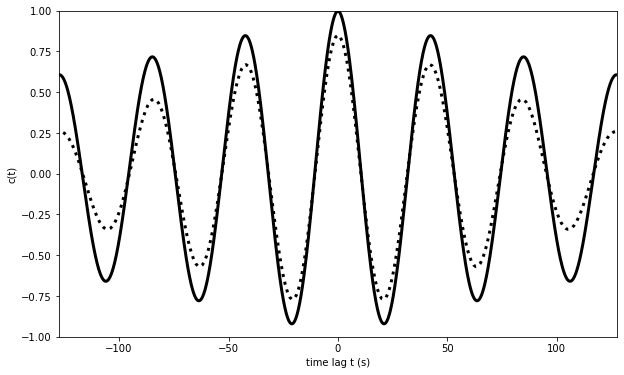

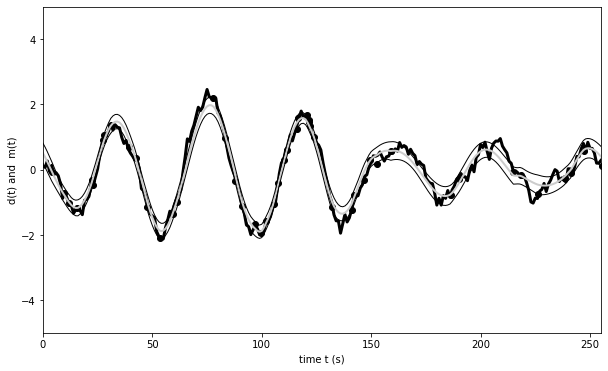

gamma: 1.0000 w0: 0.1478 s: 0.1255 n: 6.0000
target N: 50, actual 50


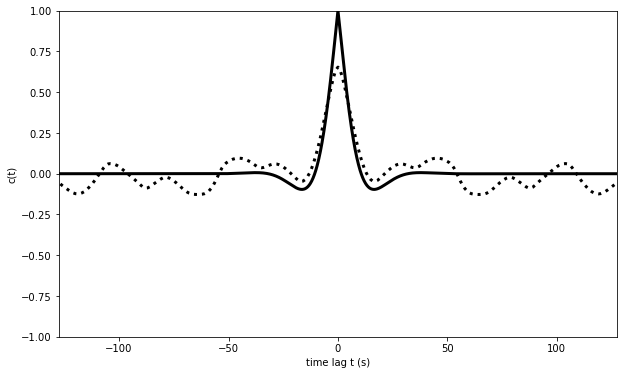

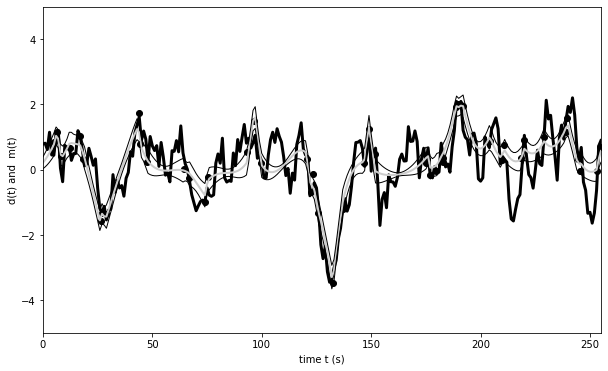

gamma: 1.0000 w0: 0.1478 s: 0.2471 n: 6.0000
target N: 50, actual 50


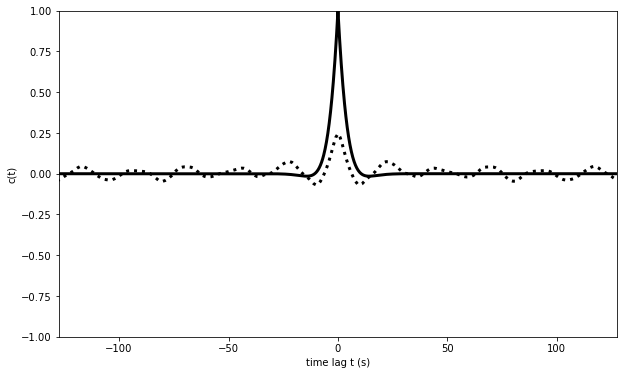

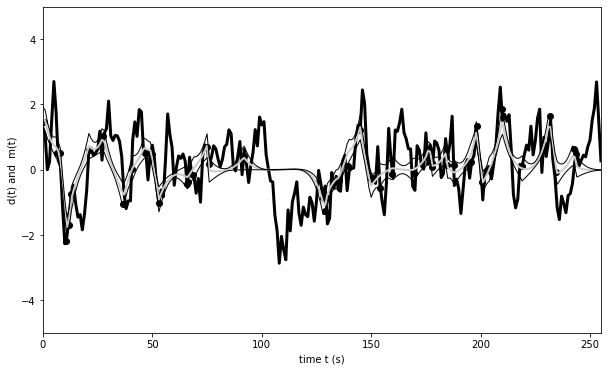

gamma: 1.0000 w0: 0.1478 s: 0.3686 n: 6.0000
target N: 50, actual 50


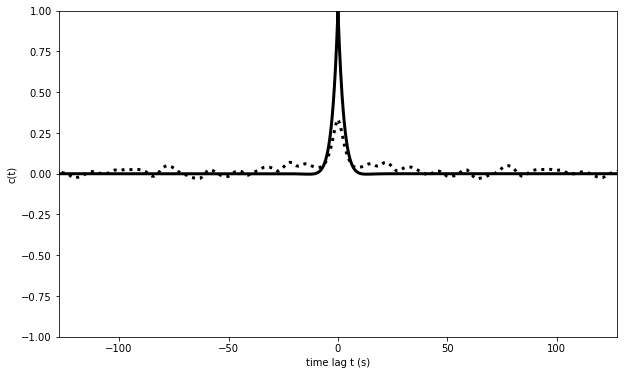

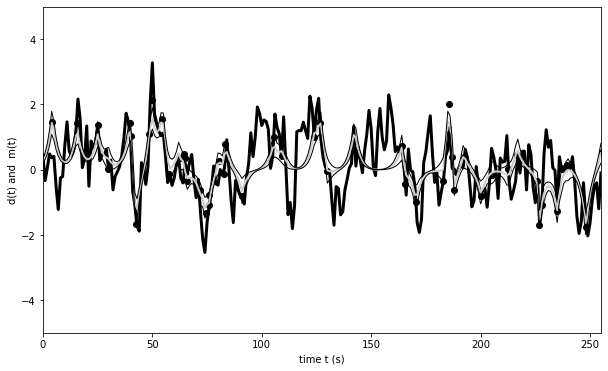

gamma: 1.0000 w0: 0.1478 s: 0.4902 n: 6.0000
target N: 50, actual 50


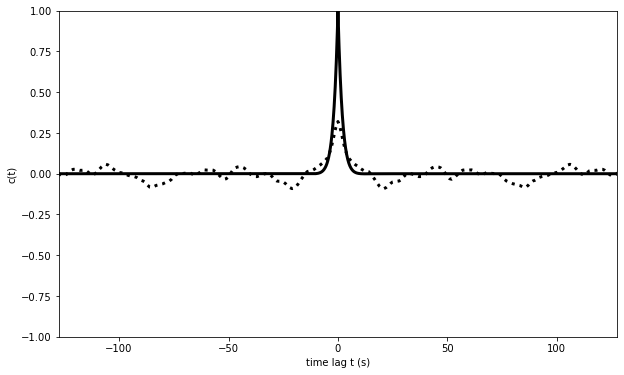

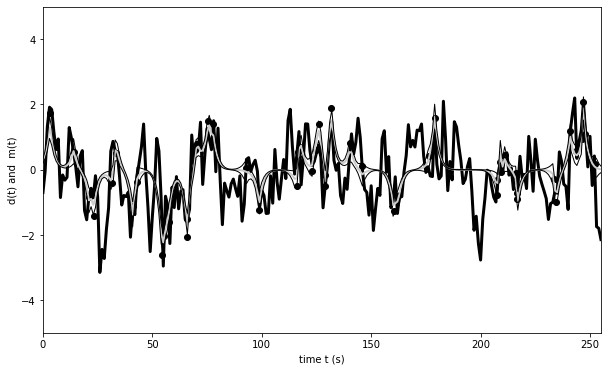

In [16]:
ss = np.linspace(1, 125, 5)
n = [6, 6, 6, 6, 6]

for i in range(5):
    gaussian(s[i], n[i])
    
#n = np.linspace(1, 20, 5);  # number of oscillations on (0,tmax) interal

gamma: 1.0000 w0: 0.0246 s: 0.0039 n: 1.0000
target N: 50, actual 50


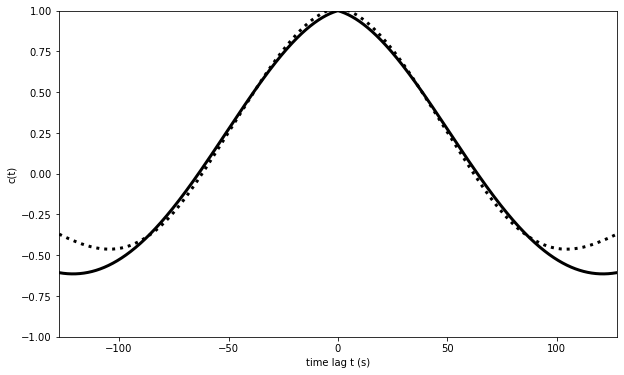

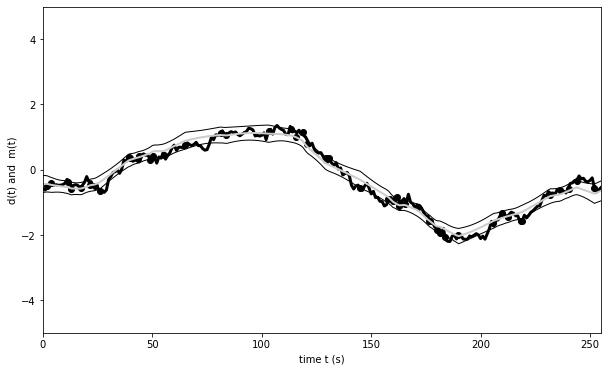

gamma: 1.0000 w0: 0.1417 s: 0.1255 n: 5.7500
target N: 50, actual 50


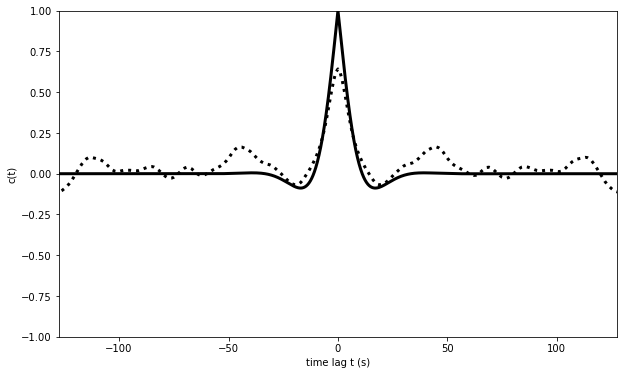

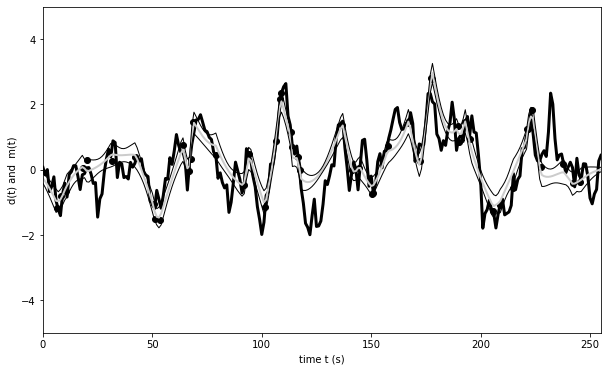

gamma: 1.0000 w0: 0.2587 s: 0.2471 n: 10.5000
target N: 50, actual 50


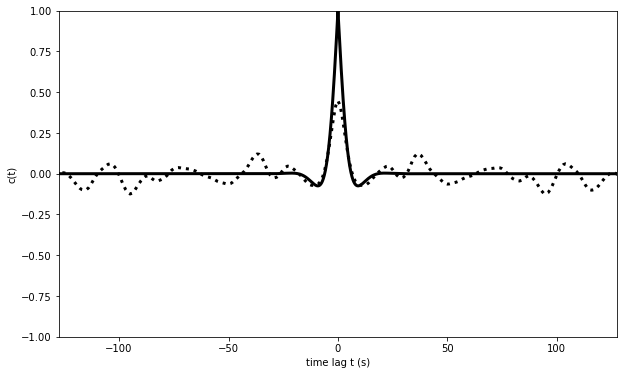

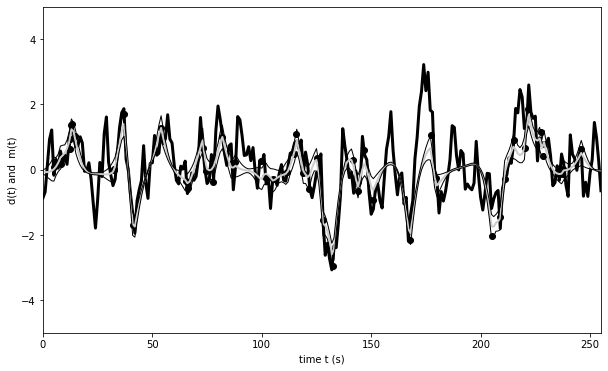

gamma: 1.0000 w0: 0.3758 s: 0.3686 n: 15.2500
target N: 50, actual 50


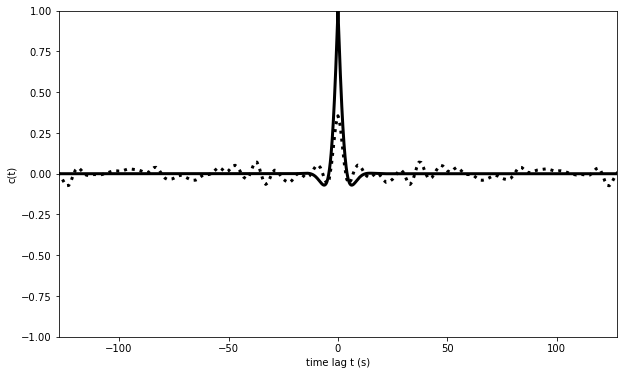

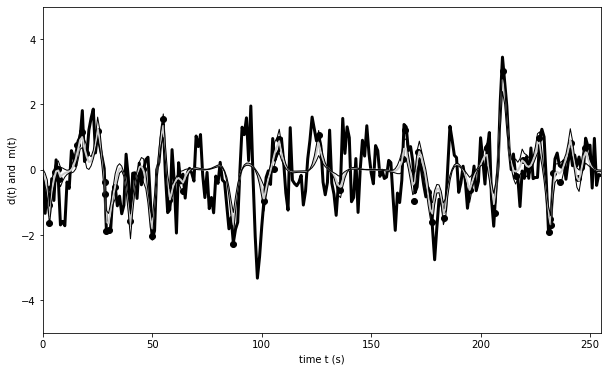

gamma: 1.0000 w0: 0.4928 s: 0.4902 n: 20.0000
target N: 50, actual 50


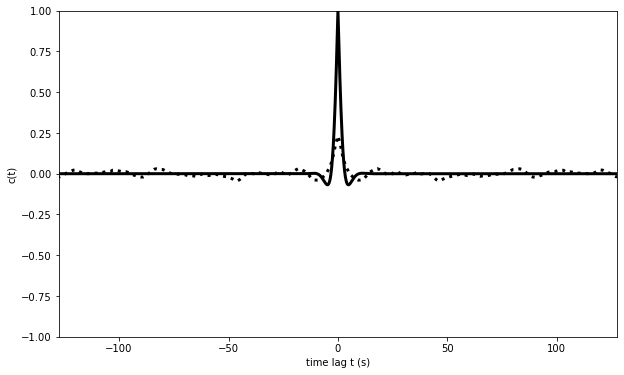

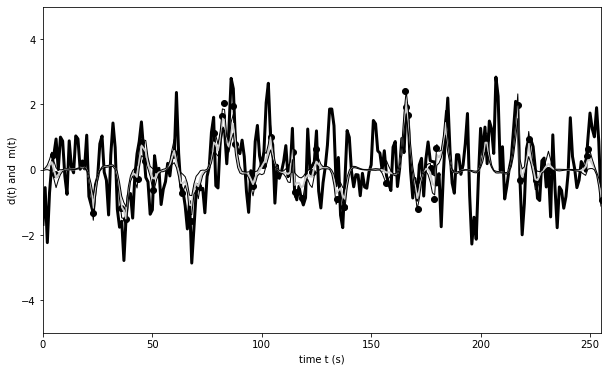

In [17]:
#Keeping decay rate, s, constant and changing ω0
n = np.linspace(1, 20, 5);  # number of oscillations on (0,tmax) interal
ss = [20, 20, 20, 20, 20]

for i in range(5):
    gaussian(s[i], n[i])

[ANSWER]

From the figures above, we can see that when we keep the ω0 constant, and change the decay rate, the time lag changes and that results in the change of the time function. The time lag has more osciallations for lower s values and lower/singular oscialltions for the higher s values. With higher values of s, the time function is more noisy and has a broader range of d(t) and m(t) values. With lower s values, the curve is smoother. 

From the figures, were we kept s constant and change the ω0 values, we can see a similar pattern for the time function. Higher n values resulting in higher ω0 values, result in noisier dt and mt functions. However, the number of the oscillations for the time lag stays constant.  

## 10.3. Modify the edama_10_05 or edapy_10_05 script to computing the kriging estimate by deleting the term σ2d in the matrix, A. Compare the results to those of the original script.

gamma: 1.0000 w0: 0.1478 s: 0.0784
target N: 50, actual 50


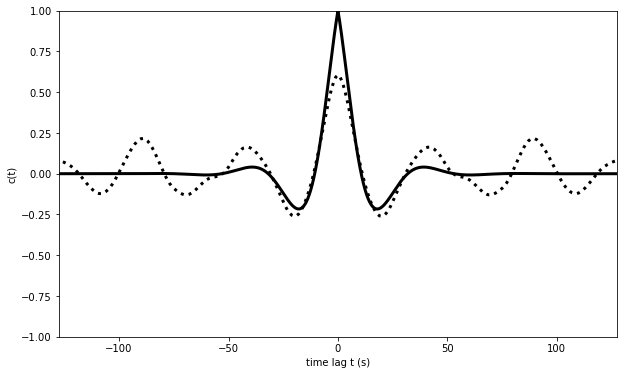

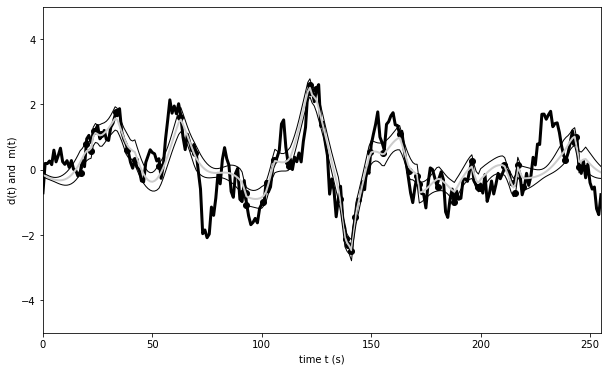

In [38]:
# edapy_10_05, Gaussian Process Regression example
# this example uses synthetic data
# and a gamma2*cos(w0T)*exp(-sT) covariance function,
# with T = |t(i)-t(j)|

# tunable parameters
MPLOT = 5;    # scale of model parameter plot
CPLOT = 1;    # scale of covariance plot
gamma = 1;    # sqrt(variance) of covariance
sigmad = 0.2; # noise level of observed data
wbias=1.0;    # compute GPR with wrong w0
sbias=1.0;    # compute GPR with wrong s
PLOTCONF=1;   # plot confidence intervals on 1
USEFORRLOOP=0; # for loops on 1, outer products on 0

# axes definitons

# model parameter axis, tm, with sampling Dt
M=256;  # must be even, best if a power of 2
Dtm=1.0;
tmax=Dtm*(M-1); 
tm=Dtm*eda_cvec(np.linspace(0,tmax,M)); 

# finely sampled model parameter vector, with sampling
# Dt/K, where K is a smallish power of 2, is used in
# the initialization process, as described below
K=8; # must be even, best if a power of 2
Mf=M*K;  
Dtf=Dtm/K;
tf=Dtf*eda_cvec(np.linspace(0,Mf-1,Mf));

# Part 1: realization of a finely sampled time
# % series, mf, with the desired covariance

# PART 1: create true "fine" covariance function

n=6;  # number of oscillations on (0,tmax) interal
w0 = n*2*pi/tmax;  # angular frequency of oscilation
tmid=tmax/2.0;
s = 20.0/tmax;     # decay rate
gamma2 = gamma**2; # variance
cf = gamma2*np.multiply(np.cos(w0*(tf-tmid)),np.exp(-s*np.abs(tf-tmid)));

print("gamma: %.4f w0: %.4f s: %.4f" % (gamma, w0, s) );

# PART 2: create "fine" time series with thus
# covariance using Fourier techniques

# amplitude spectral density of true covariance
cftilde = np.fft.fft(cf,axis=0);
cfasd = np.sqrt(np.abs(cftilde));

# To create a time series with a specified covariannce,
# start with a times series of uniformly-distrbuted
# random noise, which has a uniform a.s.d., Fourier
# transorm it, multiply teh transform by the a.s.d
# of the specified covariance, trasnform back, and adjust
# the amplitude to the desired variance.
# random numbers
mf = np.random.normal(loc=0.0,scale=1.0,size=(Mf,1));
mf = mf - np.mean(mf); # remove mean
mftilde = np.fft.fft(mf,axis=0); # Fourier transform of mf
mfasd = np.abs(mftilde);   # a.s.d. of mf
# adjust so has a.s.d. of c
mftilde = np.multiply(np.divide(cfasd,mfasd),mftilde);
# inverse Fourier transform
mf = np.real(np.fft.ifft(mftilde,axis=0));
varmf = np.var(mf);      # variance of mf
# normalize mf to variance gamma^2
mf = (gamma/sqrt(varmf))*mf;

# PART 3: Regularly sub-sample mf to get mtrue, irregularly
# sub-sample mf to get true data dtrue, and add uncorrelated
# noise to dtrue to get observed data dobs

mtrue = np.copy(mf[0:Mf:K]);

Ntarget = 50; # fewer observed data than true data
# create list, j, of N unique, randomly chosen indices
# that are not in the sequence 1, K+1, 2K+1, ...
j=np.zeros((Ntarget,1),dtype=int);
Nj=0;
while (Nj<Ntarget):
    i=np.random.randint(low=0,high=Mf-1,size=(1));
    if( (((i-1)%K) != 0) and (not np.isin(i,j)) ):
        j[Nj,0]=i;
        Nj=Nj+1;
# sort for plotting purposes
j = eda_cvec(np.sort(j.ravel())); 
j = eda_cvec(np.unique(j.ravel())); 
N,i = np.shape(j);
print('target N: %d, actual %d' % (Ntarget,N) );
# times of observations
td = np.copy(tf[j.ravel()]); 
# irregularly sub-sampled data
dtrue = np.copy(mf[j.ravel()]);  
# observed data is true data + uncorrelated random noise
sigmad2 = sigmad**2;
dobs = dtrue+np.random.normal(loc=0,scale=sigmad,size=(N,1));

# the data kernel, G, for the equation d=Gm
G = np.concatenate( (np.zeros((N,M)), np.zeros((N,N))), axis=1 );

# Since the true (w0, s) are in general unknown
# this code allows them to be assigned differently
# from the true values
w0est = wbias*w0;  # w0est = 1.0*w0 is the true value
sest = sbias*s;

if( USEFORRLOOP ):
    # build covariances via for loop
    Ccc = np.zeros((N,N)); # covariance matrix, C(control,control)
    for i in range(N):
        for j in range(N):
            T = abs(td[i,0]-td[j,0]);
            Ccc[i,j] = gamma2*cos(w0est*T)*exp(-sest*T);
    
    Ctc = np.zeros((M,N)); #  covariance matrix, C(target,control)
    for i in range(M):
        for j in range(N):
            T = abs(tm[i,0]-td[j,0]);
            Ctc[i,j] = gamma2*cos(w0est*T)*exp(-sest*T);   
else: # use outer product
    # build covariances via outer product
    Tdd = np.abs(np.matmul(td,np.ones((1,N)))-np.matmul(np.ones((N,1)),(td.T)));
    Ccc = gamma2*np.multiply(np.cos(w0est*Tdd),np.exp(-sest*Tdd));
    Tmd = np.abs(np.matmul(tm,np.ones((1,N)))-np.matmul(np.ones((M,1)),(td.T)));
    Ctc = gamma2*np.multiply(np.cos(w0est*Tmd),np.exp(-sest*Tmd));

# solve GPE problem
A = (Ccc + sigmad2*np.identity(N) );
mest = np.matmul(Ctc,la.solve(A,dobs));

# estimated covariance
cest = eda_cvec(
    np.correlate(mest.ravel(),mest.ravel(),mode='full'))/M;

# plot this covariance
fig1 = plt.figure(1,figsize=(10,6));
plt.axis([ -tmid, tmid, -CPLOT, CPLOT]);
plt.xlabel('time lag t (s)');
plt.ylabel('c(t)');
plt.plot( tf-tmid,cf,'k-',lw=3);
tc = eda_cvec(Dtm*np.linspace(-M+1,M-1,2*M-1));
plt.plot(tc,cest,'k:',lw=3);
plt.show();

# time series figure
fig2 = plt.figure(2,figsize=(10,6));
plt.axis( [ 0, tmax, -MPLOT, MPLOT] );
plt.xlabel('time t (s)');
plt.ylabel('d(t) and  m(t)');
plt.plot(tm,mtrue,'k-',lw=3);
plt.plot(td,dtrue,'ko',lw=2);
plt.plot(tm,mest,'-',lw=2,color=[0.8,0.8,0.8]);
if( PLOTCONF ): # plot 95% confidence intervals
    # MATLAB: B = Ctc/A solves BA = Ctc
    # take transpose, so AT BT = CctT, then solve for BT
    # BT = solve(AT,CtcT) = solve(A,CtcT), since A=AT
    # MATLAB: B BT becomes BTT * BT
    BT = la.solve(A,Ctc.T)
    Cttest = sigmad2*np.matmul(BT.T,BT);
    sigmamest = np.sqrt(eda_cvec(np.diag(Cttest)));
    plt.plot(tm,mest-2*sigmamest,'k-',lw=1);
    plt.plot(tm,mest+2*sigmamest,'k-',lw=1);
plt.show();

gamma: 1.0000 w0: 0.1478 s: 0.0784
target N: 50, actual 50


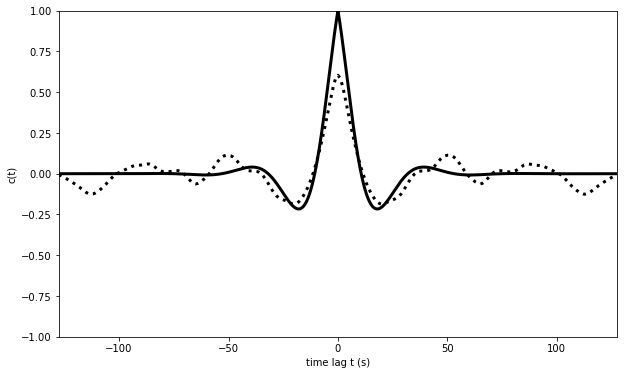

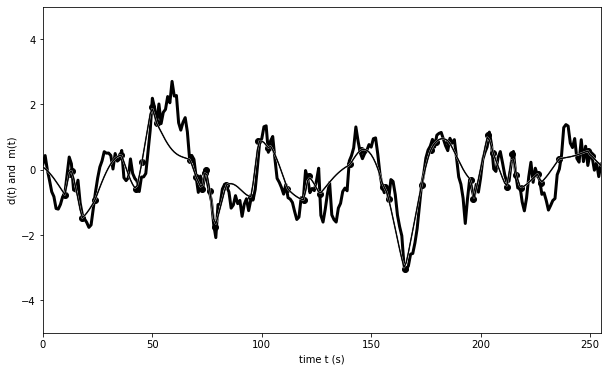

In [40]:
# edapy_10_05, Gaussian Process Regression example
# this example uses synthetic data
# and a gamma2*cos(w0T)*exp(-sT) covariance function,
# with T = |t(i)-t(j)|

# tunable parameters
MPLOT = 5;    # scale of model parameter plot
CPLOT = 1;    # scale of covariance plot
gamma = 1;    # sqrt(variance) of covariance
sigmad = 0; # noise level of observed data
wbias=1.0;    # compute GPR with wrong w0
sbias=1.0;    # compute GPR with wrong s
PLOTCONF=1;   # plot confidence intervals on 1
USEFORRLOOP=0; # for loops on 1, outer products on 0

# axes definitons

# model parameter axis, tm, with sampling Dt
M=256;  # must be even, best if a power of 2
Dtm=1.0;
tmax=Dtm*(M-1); 
tm=Dtm*eda_cvec(np.linspace(0,tmax,M)); 

# finely sampled model parameter vector, with sampling
# Dt/K, where K is a smallish power of 2, is used in
# the initialization process, as described below
K=8; # must be even, best if a power of 2
Mf=M*K;  
Dtf=Dtm/K;
tf=Dtf*eda_cvec(np.linspace(0,Mf-1,Mf));

# Part 1: realization of a finely sampled time
# % series, mf, with the desired covariance

# PART 1: create true "fine" covariance function

n=6;  # number of oscillations on (0,tmax) interal
w0 = n*2*pi/tmax;  # angular frequency of oscilation
tmid=tmax/2.0;
s = 20.0/tmax;     # decay rate
gamma2 = gamma**2; # variance
cf = gamma2*np.multiply(np.cos(w0*(tf-tmid)),np.exp(-s*np.abs(tf-tmid)));

print("gamma: %.4f w0: %.4f s: %.4f" % (gamma, w0, s) );

# PART 2: create "fine" time series with thus
# covariance using Fourier techniques

# amplitude spectral density of true covariance
cftilde = np.fft.fft(cf,axis=0);
cfasd = np.sqrt(np.abs(cftilde));

# To create a time series with a specified covariannce,
# start with a times series of uniformly-distrbuted
# random noise, which has a uniform a.s.d., Fourier
# transorm it, multiply teh transform by the a.s.d
# of the specified covariance, trasnform back, and adjust
# the amplitude to the desired variance.
# random numbers
mf = np.random.normal(loc=0.0,scale=1.0,size=(Mf,1));
mf = mf - np.mean(mf); # remove mean
mftilde = np.fft.fft(mf,axis=0); # Fourier transform of mf
mfasd = np.abs(mftilde);   # a.s.d. of mf
# adjust so has a.s.d. of c
mftilde = np.multiply(np.divide(cfasd,mfasd),mftilde);
# inverse Fourier transform
mf = np.real(np.fft.ifft(mftilde,axis=0));
varmf = np.var(mf);      # variance of mf
# normalize mf to variance gamma^2
mf = (gamma/sqrt(varmf))*mf;

# PART 3: Regularly sub-sample mf to get mtrue, irregularly
# sub-sample mf to get true data dtrue, and add uncorrelated
# noise to dtrue to get observed data dobs

mtrue = np.copy(mf[0:Mf:K]);

Ntarget = 50; # fewer observed data than true data
# create list, j, of N unique, randomly chosen indices
# that are not in the sequence 1, K+1, 2K+1, ...
j=np.zeros((Ntarget,1),dtype=int);
Nj=0;
while (Nj<Ntarget):
    i=np.random.randint(low=0,high=Mf-1,size=(1));
    if( (((i-1)%K) != 0) and (not np.isin(i,j)) ):
        j[Nj,0]=i;
        Nj=Nj+1;
# sort for plotting purposes
j = eda_cvec(np.sort(j.ravel())); 
j = eda_cvec(np.unique(j.ravel())); 
N,i = np.shape(j);
print('target N: %d, actual %d' % (Ntarget,N) );
# times of observations
td = np.copy(tf[j.ravel()]); 
# irregularly sub-sampled data
dtrue = np.copy(mf[j.ravel()]);  
# observed data is true data + uncorrelated random noise
sigmad2 = sigmad**2;
dobs = dtrue+np.random.normal(loc=0,scale=sigmad,size=(N,1));

# the data kernel, G, for the equation d=Gm
G = np.concatenate( (np.zeros((N,M)), np.zeros((N,N))), axis=1 );

# Since the true (w0, s) are in general unknown
# this code allows them to be assigned differently
# from the true values
w0est = wbias*w0;  # w0est = 1.0*w0 is the true value
sest = sbias*s;

if( USEFORRLOOP ):
    # build covariances via for loop
    Ccc = np.zeros((N,N)); # covariance matrix, C(control,control)
    for i in range(N):
        for j in range(N):
            T = abs(td[i,0]-td[j,0]);
            Ccc[i,j] = gamma2*cos(w0est*T)*exp(-sest*T);
    
    Ctc = np.zeros((M,N)); #  covariance matrix, C(target,control)
    for i in range(M):
        for j in range(N):
            T = abs(tm[i,0]-td[j,0]);
            Ctc[i,j] = gamma2*cos(w0est*T)*exp(-sest*T);   
else: # use outer product
    # build covariances via outer product
    Tdd = np.abs(np.matmul(td,np.ones((1,N)))-np.matmul(np.ones((N,1)),(td.T)));
    Ccc = gamma2*np.multiply(np.cos(w0est*Tdd),np.exp(-sest*Tdd));
    Tmd = np.abs(np.matmul(tm,np.ones((1,N)))-np.matmul(np.ones((M,1)),(td.T)));
    Ctc = gamma2*np.multiply(np.cos(w0est*Tmd),np.exp(-sest*Tmd));

# solve GPE problem
A = (Ccc + sigmad2*np.identity(N) );
mest = np.matmul(Ctc,la.solve(A,dobs));

# estimated covariance
cest = eda_cvec(
    np.correlate(mest.ravel(),mest.ravel(),mode='full'))/M;

# plot this covariance
fig1 = plt.figure(1,figsize=(10,6));
plt.axis([ -tmid, tmid, -CPLOT, CPLOT]);
plt.xlabel('time lag t (s)');
plt.ylabel('c(t)');
plt.plot( tf-tmid,cf,'k-',lw=3);
tc = eda_cvec(Dtm*np.linspace(-M+1,M-1,2*M-1));
plt.plot(tc,cest,'k:',lw=3);
plt.show();

# time series figure
fig2 = plt.figure(2,figsize=(10,6));
plt.axis( [ 0, tmax, -MPLOT, MPLOT] );
plt.xlabel('time t (s)');
plt.ylabel('d(t) and  m(t)');
plt.plot(tm,mtrue,'k-',lw=3);
plt.plot(td,dtrue,'ko',lw=2);
plt.plot(tm,mest,'-',lw=2,color=[0.8,0.8,0.8]);
if( PLOTCONF ): # plot 95% confidence intervals
    # MATLAB: B = Ctc/A solves BA = Ctc
    # take transpose, so AT BT = CctT, then solve for BT
    # BT = solve(AT,CtcT) = solve(A,CtcT), since A=AT
    # MATLAB: B BT becomes BTT * BT
    BT = la.solve(A,Ctc.T)
    Cttest = sigmad2*np.matmul(BT.T,BT);
    sigmamest = np.sqrt(eda_cvec(np.diag(Cttest)));
    plt.plot(tm,mest-2*sigmamest,'k-',lw=1);
    plt.plot(tm,mest+2*sigmamest,'k-',lw=1);
plt.show();

    

[ANSWER]
In changing the value of sigma from 0.2 to 0, we can see that it reflected in the output of the time functions. With a sigmad2 of 0, the time function is less noisy, has lower frequencies, lower amplitudes etc. 

## 10.4. Modify the edama_10_05 or edapy_10_05 script to use the covariance function: 
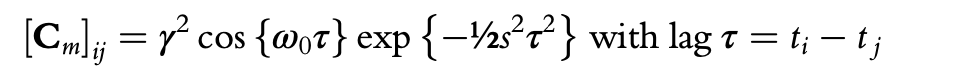
## and compare both the true time series and the interpolated one to those of the original script.

gamma: 1.0000 w0: 0.1478 s: 0.0784
target N: 50, actual 50


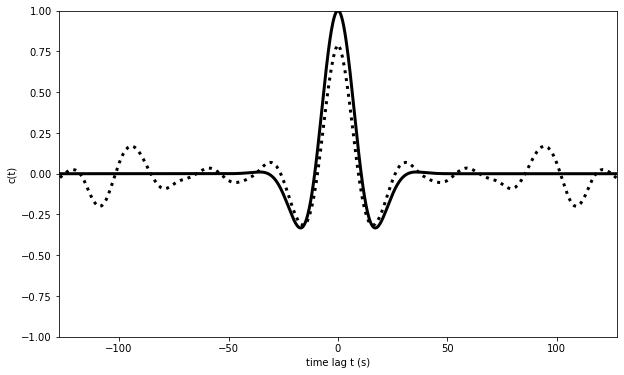

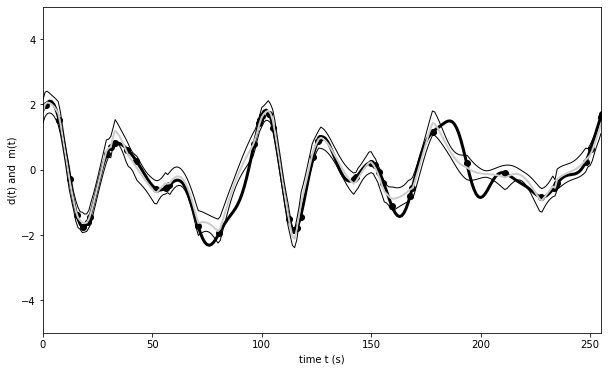

In [41]:
# edapy_10_05, Gaussian Process Regression example
# this example uses synthetic data
# and a gamma2*cos(w0T)*exp(-sT) covariance function,
# with T = |t(i)-t(j)|

# tunable parameters
MPLOT = 5;    # scale of model parameter plot
CPLOT = 1;    # scale of covariance plot
gamma = 1;    # sqrt(variance) of covariance
sigmad = 0.2; # noise level of observed data
wbias=1.0;    # compute GPR with wrong w0
sbias=1.0;    # compute GPR with wrong s
PLOTCONF=1;   # plot confidence intervals on 1
USEFORRLOOP=0; # for loops on 1, outer products on 0

# axes definitons

# model parameter axis, tm, with sampling Dt
M=256;  # must be even, best if a power of 2
Dtm=1.0;
tmax=Dtm*(M-1); 
tm=Dtm*eda_cvec(np.linspace(0,tmax,M)); 

# finely sampled model parameter vector, with sampling
# Dt/K, where K is a smallish power of 2, is used in
# the initialization process, as described below
K=8; # must be even, best if a power of 2
Mf=M*K;  
Dtf=Dtm/K;
tf=Dtf*eda_cvec(np.linspace(0,Mf-1,Mf));

# Part 1: realization of a finely sampled time
# % series, mf, with the desired covariance

# PART 1: create true "fine" covariance function

n=6;  # number of oscillations on (0,tmax) interal
w0 = n*2*pi/tmax;  # angular frequency of oscilation
tmid=tmax/2.0;
s = 20.0/tmax;     # decay rate
gamma2 = gamma**2; # variance
#gamma2*cos(w0T)*exp(-sT) covariance function,=> 1⁄2s2τ2
xx = np.exp(-0.5*((s**2)*(tf-tmid)**2));
cf = gamma2*np.multiply(np.cos(w0*(tf-tmid)),np.exp(-0.5*((s**2)*(tf-tmid)**2)));

print("gamma: %.4f w0: %.4f s: %.4f" % (gamma, w0, s) );

# PART 2: create "fine" time series with thus
# covariance using Fourier techniques

# amplitude spectral density of true covariance
cftilde = np.fft.fft(cf,axis=0);
cfasd = np.sqrt(np.abs(cftilde));

# To create a time series with a specified covariannce,
# start with a times series of uniformly-distrbuted
# random noise, which has a uniform a.s.d., Fourier
# transorm it, multiply teh transform by the a.s.d
# of the specified covariance, trasnform back, and adjust
# the amplitude to the desired variance.
# random numbers
mf = np.random.normal(loc=0.0,scale=1.0,size=(Mf,1));
mf = mf - np.mean(mf); # remove mean
mftilde = np.fft.fft(mf,axis=0); # Fourier transform of mf
mfasd = np.abs(mftilde);   # a.s.d. of mf
# adjust so has a.s.d. of c
mftilde = np.multiply(np.divide(cfasd,mfasd),mftilde);
# inverse Fourier transform
mf = np.real(np.fft.ifft(mftilde,axis=0));
varmf = np.var(mf);      # variance of mf
# normalize mf to variance gamma^2
mf = (gamma/sqrt(varmf))*mf;

# PART 3: Regularly sub-sample mf to get mtrue, irregularly
# sub-sample mf to get true data dtrue, and add uncorrelated
# noise to dtrue to get observed data dobs

mtrue = np.copy(mf[0:Mf:K]);

Ntarget = 50; # fewer observed data than true data
# create list, j, of N unique, randomly chosen indices
# that are not in the sequence 1, K+1, 2K+1, ...
j=np.zeros((Ntarget,1),dtype=int);
Nj=0;
while (Nj<Ntarget):
    i=np.random.randint(low=0,high=Mf-1,size=(1));
    if( (((i-1)%K) != 0) and (not np.isin(i,j)) ):
        j[Nj,0]=i;
        Nj=Nj+1;
# sort for plotting purposes
j = eda_cvec(np.sort(j.ravel())); 
j = eda_cvec(np.unique(j.ravel())); 
N,i = np.shape(j);
print('target N: %d, actual %d' % (Ntarget,N) );
# times of observations
td = np.copy(tf[j.ravel()]); 
# irregularly sub-sampled data
dtrue = np.copy(mf[j.ravel()]);  
# observed data is true data + uncorrelated random noise
sigmad2 = sigmad**2;
dobs = dtrue+np.random.normal(loc=0,scale=sigmad,size=(N,1));

# the data kernel, G, for the equation d=Gm
G = np.concatenate( (np.zeros((N,M)), np.zeros((N,N))), axis=1 );

# Since the true (w0, s) are in general unknown
# this code allows them to be assigned differently
# from the true values
w0est = wbias*w0;  # w0est = 1.0*w0 is the true value
sest = sbias*s;

if( USEFORRLOOP ):
    # build covariances via for loop
    Ccc = np.zeros((N,N)); # covariance matrix, C(control,control)
    for i in range(N):
        for j in range(N):
            T = abs(td[i,0]-td[j,0]);
            Ccc[i,j] = gamma2*cos(w0est*T)*exp(-sest*T);
    
    Ctc = np.zeros((M,N)); #  covariance matrix, C(target,control)
    for i in range(M):
        for j in range(N):
            T = abs(tm[i,0]-td[j,0]);
            Ctc[i,j] = gamma2*cos(w0est*T)*exp(-sest*T);   
else: # use outer product
    # build covariances via outer product
    Tdd = np.abs(np.matmul(td,np.ones((1,N)))-np.matmul(np.ones((N,1)),(td.T)));
    Ccc = gamma2*np.multiply(np.cos(w0est*Tdd),np.exp(-sest*Tdd));
    Tmd = np.abs(np.matmul(tm,np.ones((1,N)))-np.matmul(np.ones((M,1)),(td.T)));
    Ctc = gamma2*np.multiply(np.cos(w0est*Tmd),np.exp(-sest*Tmd));

# solve GPE problem
A = (Ccc + sigmad2*np.identity(N) );
mest = np.matmul(Ctc,la.solve(A,dobs));

# estimated covariance
cest = eda_cvec(
    np.correlate(mest.ravel(),mest.ravel(),mode='full'))/M;

# plot this covariance
fig1 = plt.figure(1,figsize=(10,6));
plt.axis([ -tmid, tmid, -CPLOT, CPLOT]);
plt.xlabel('time lag t (s)');
plt.ylabel('c(t)');
plt.plot( tf-tmid,cf,'k-',lw=3);
tc = eda_cvec(Dtm*np.linspace(-M+1,M-1,2*M-1));
plt.plot(tc,cest,'k:',lw=3);
plt.show();

# time series figure
fig2 = plt.figure(2,figsize=(10,6));
plt.axis( [ 0, tmax, -MPLOT, MPLOT] );
plt.xlabel('time t (s)');
plt.ylabel('d(t) and  m(t)');
plt.plot(tm,mtrue,'k-',lw=3);
plt.plot(td,dtrue,'ko',lw=2);
plt.plot(tm,mest,'-',lw=2,color=[0.8,0.8,0.8]);
if( PLOTCONF ): # plot 95% confidence intervals
    # MATLAB: B = Ctc/A solves BA = Ctc
    # take transpose, so AT BT = CctT, then solve for BT
    # BT = solve(AT,CtcT) = solve(A,CtcT), since A=AT
    # MATLAB: B BT becomes BTT * BT
    BT = la.solve(A,Ctc.T)
    Cttest = sigmad2*np.matmul(BT.T,BT);
    sigmamest = np.sqrt(eda_cvec(np.diag(Cttest)));
    plt.plot(tm,mest-2*sigmamest,'k-',lw=1);
    plt.plot(tm,mest+2*sigmamest,'k-',lw=1);
plt.show();

[ANSWER]
The output from this time function is significantly less noisy. There are much less oscillations/ lower frequency. 